# Example: Creating Mixed-Element Mesh Workflow



In [29]:
# conda package imports
import numpy as np
from matplotlib import pyplot as plt
import logging
import copy
import shapely

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.crs
import watershed_workflow.densification
import watershed_workflow.mesh
watershed_workflow.ui.setup_logging(1,None)

%matplotlib ipympl

In [16]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
coweeta_shapefile = '../../Coweeta_data/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
name = 'Coweeta'

figsize = (6,6)
figsize_3d = (8,6)

# Geomtric parameters tuning the degree of cleaning of the raw data and scales of hydrologic features to be considered
simplify = 60 # length scale to target average edge
ignore_small_rivers = 2 
prune_by_area_fraction = 0.01 

# huc boundary refinement control
refine_d0 = 20
refine_d1 = 100
refine_L0 = 70
refine_L1 = 200

In [17]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [40]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = '../../Coweeta_data/input_data/DEM/coweeta_dem.tif'

### Get HUCs

In [19]:
# load hucs from shape
_, watershed = watershed_workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)

2024-11-10 15:30:33,079 - root - INFO: 
2024-11-10 15:30:33,080 - root - INFO: Loading shapes
2024-11-10 15:30:33,080 - root - INFO: ------------------------------
2024-11-10 15:30:33,080 - root - INFO: Loading file: '../../Coweeta_data/input_data/coweeta_basin.shp'
2024-11-10 15:30:33,082 - root - INFO: ... found 1 shapes
2024-11-10 15:30:33,082 - root - INFO: Converting to shapely
2024-11-10 15:30:33,083 - root - INFO:  ... done
2024-11-10 15:30:33,086 - root - INFO: Converting to requested CRS
2024-11-10 15:30:33,092 - root - INFO:  ... done
2024-11-10 15:30:33,092 - root - INFO: Removing holes on 1 polygons
2024-11-10 15:30:33,092 - root - INFO:   -- removed interior
2024-11-10 15:30:33,093 - root - INFO:   -- union
2024-11-10 15:30:33,093 - root - INFO: Parsing 1 components for holes
2024-11-10 15:30:33,093 - root - INFO:   -- complete


### Get Rivers 

In [20]:
include_rivers=True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], hint, 
                                                watershed.exterior(), crs, crs,
                                                in_network=True, properties=True)
    
    rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq',
                                                 ignore_small_rivers=ignore_small_rivers,
                                                 prune_by_area=prune_by_area_fraction * watershed.exterior().area * 1.e-6,
                                                 remove_diversions=True,
                                                 remove_braided_divergences=True)
    
    # keeping the originals
    rivers_orig=[river.deepcopy() for river in rivers]
    watershed_orig=copy.deepcopy(watershed) 
    
    # simplifying 
    rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                               snap_tol=0.75*simplify, cut_intersections=True)
    
    # for plotting purpose only
    rivers_simplified=[river.deepcopy() for river in rivers] 
    watershed_simplified=copy.deepcopy(watershed) 

else:
    reaches = []
    rivers = []

2024-11-10 15:30:33,103 - root - INFO: 
2024-11-10 15:30:33,103 - root - INFO: Loading Hydrography
2024-11-10 15:30:33,103 - root - INFO: ------------------------------
2024-11-10 15:30:33,104 - root - INFO: Loading streams in HUC 0601
2024-11-10 15:30:33,104 - root - INFO:          and/or bounds (1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)
2024-11-10 15:30:33,104 - root - INFO:   Using Hydrography file "/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2024-11-10 15:30:33,105 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)'
2024-11-10 15:30:34,291 - root - INFO:   Found total of 44 in bounds.
2024-11-10 15:30:34,293 - root - INFO: Filtering reaches not in-

### Densification of River Network and Watershed

In [21]:
d0 = refine_d0; d1 = refine_d1
L0 = refine_L0; L1 = refine_L1 

# densify_watershed
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=[d0,L0,d1,L1]) 

#densify_river
watershed_workflow.densification.densify_rivers_new(rivers, limit=70)


# treat sharp angles
watershed_workflow.densification.remove_sharp_angles(rivers, watershed, angle_limit=10, junction_angle_limit=10, huc_seg_river_angle_limit=10, limit=70)

2024-11-10 15:30:39,728 - root - INFO:   river min seg length: 61.98201607276061
2024-11-10 15:30:39,728 - root - INFO:   river median seg length: 68.58412894200525
2024-11-10 15:30:39,762 - root - INFO: removing sharp angle between river and huc: 9.328301133171266 for node 25000400040729


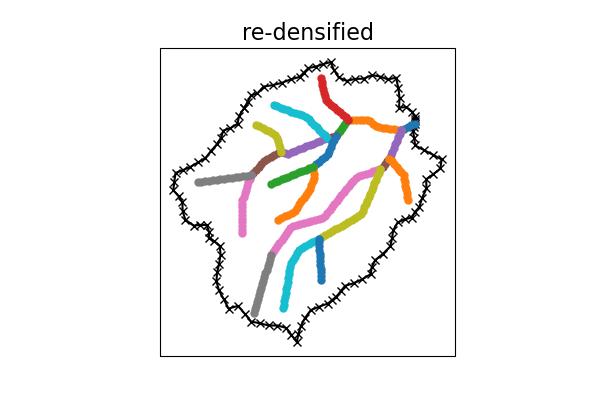

In [22]:
# plot re-densified watershed and river network
fig, ax = plt.subplots(subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)}, figsize=(6,4))

ax.plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
ax.set_title('re-densified',fontsize=16)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        ax.plot(x,y,'-o',markersize=5)
plt.show()

In [23]:
# how many types of Stream Orders are there
set([r.properties["StreamOrder"] for r in rivers[0].preOrder()])

{1, 2, 3}

### 1) Base Case Meshing


<b> Select widths that ensures the aspect ratio of the quadrilateral elements remains elongated. This is important to avoid potential complications in defining the mesh topology. </b>

<b>Tessellation</b> process involes following steps:

- Creation of river-corridor polygon with prescribed widths
- Triangulation with river-corridor polygon as a hole (with no steiner points allowed). We also provide mesh quality criteria like criteria like angle and area constraints 
- Appending river-mesh elements to TIN-mesh elements creating a complete stream-aligned mixed-element mesh

# <img src="../images/coweeta_workflow.png" width="800"/>


2024-11-10 15:45:59,181 - root - INFO: 
2024-11-10 15:45:59,189 - root - INFO: Stream-aligned Meshing
2024-11-10 15:45:59,191 - root - INFO: ------------------------------
2024-11-10 15:45:59,192 - root - INFO: treat stream triangles is set to None
2024-11-10 15:45:59,200 - root - INFO: Creating stream-aligned mesh...
2024-11-10 15:45:59,213 - root - INFO: River 0
2024-11-10 15:45:59,217 - root - INFO: ... generating initial polygon through dilation (4 m)
2024-11-10 15:45:59,225 - root - INFO:   -- treating collinearity
2024-11-10 15:45:59,240 - root - INFO:   -- river min seg length: 61.98201607276061
2024-11-10 15:45:59,241 - root - INFO:   -- merging points closer than 45.98201607276061 m along the river corridor
2024-11-10 15:45:59,246 - root - INFO: ... defining river-mesh topology (quad elements)
2024-11-10 15:45:59,268 - root - INFO: ... setting width of quad elements
2024-11-10 15:45:59,273 - root - INFO: ... enforcing convexity
2024-11-10 15:45:59,276 - root - INFO: Adjusting 

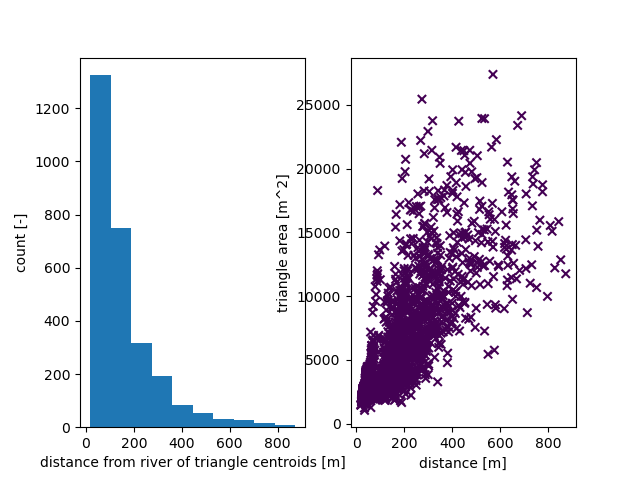

In [68]:
## Triangulation

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width)
widths = dict({1:8,2:12,3:16})

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle, refine_max_area=30000,
                                              diagnostics=True)

# try refine area = 10000, 20000 and 50000


In [66]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), conn_list)

2024-11-10 15:45:47,908 - root - INFO: 
2024-11-10 15:45:47,919 - root - INFO: Loading Raster
2024-11-10 15:45:47,922 - root - INFO: ------------------------------
2024-11-10 15:45:47,924 - root - INFO: Loading file: '../../Coweeta_data/input_data/DEM/coweeta_dem.tif'
2024-11-10 15:45:47,930 - root - INFO: Collecting raster
2024-11-10 15:45:47,941 - root - INFO: bounds in my_crs: (-83.47845037186387, 35.02734099944037, -83.42165773504303, 35.07381933600275)
2024-11-10 15:45:47,942 - root - INFO: ... got raster of shape: (169, 206)
2024-11-10 15:45:47,943 - root - INFO: ... got raster bounds: (-83.47872814964133, 35.074097113780205, -83.4215059274172, 35.0271526693342)


kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x31ea59db0>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x31ea5bbb0>, 'edgecolor': 'k'}
setting face color =  [1341.90253697  856.17069616  899.94551301 ...  874.57965231  886.21624931
  896.01467586]


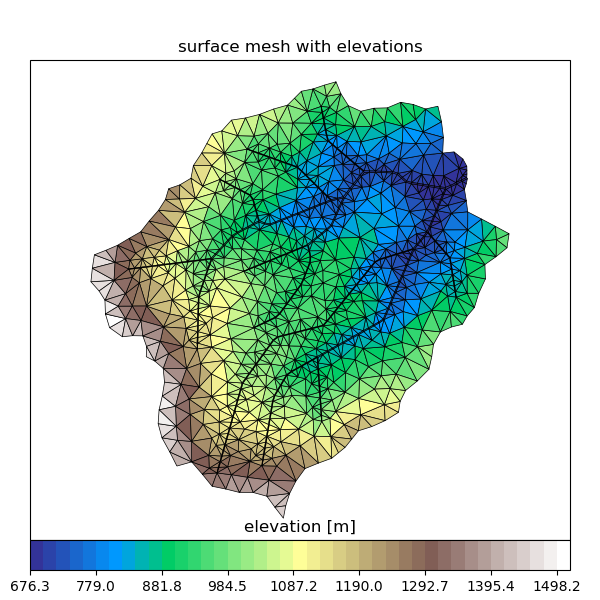

In [67]:
# plotting surface mesh with elevations
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='terrain')


fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.5 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

cbar.ax.set_title('elevation [m]')

plt.show()


### 2) Refine based on the distance from the river

In [ ]:
## Triangulation

d0 = 25; d1 = 200
A0 = 500; A1 = 40000 

# Refine triangles if they get too acute
min_angle = 22.5 # degrees

# width of reach by stream order (order:width)
widths = dict({1:4,2:5,3:5,4:15,5:22}) 

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle,refine_distance=[d0,A0,d1,A1], treat_stream_triangles='strict',#additional_points=additional_points,
                                              diagnostics=True)

2024-11-10 15:49:45,048 - root - INFO: 
2024-11-10 15:49:45,049 - root - INFO: Stream-aligned Meshing
2024-11-10 15:49:45,049 - root - INFO: ------------------------------
2024-11-10 15:49:45,049 - root - INFO: treat stream triangles is set to None
2024-11-10 15:49:45,050 - root - INFO: Creating stream-aligned mesh...
2024-11-10 15:49:45,050 - root - INFO: River 0
2024-11-10 15:49:45,051 - root - INFO: ... generating initial polygon through dilation (4 m)
2024-11-10 15:49:45,053 - root - INFO:   -- treating collinearity
2024-11-10 15:49:45,058 - root - INFO:   -- river min seg length: 61.98201607276061
2024-11-10 15:49:45,058 - root - INFO:   -- merging points closer than 45.98201607276061 m along the river corridor
2024-11-10 15:49:45,063 - root - INFO: ... defining river-mesh topology (quad elements)
2024-11-10 15:49:45,138 - root - INFO: ... setting width of quad elements
2024-11-10 15:49:45,143 - root - INFO: ... enforcing convexity
2024-11-10 15:49:45,146 - root - INFO: Adjusting 

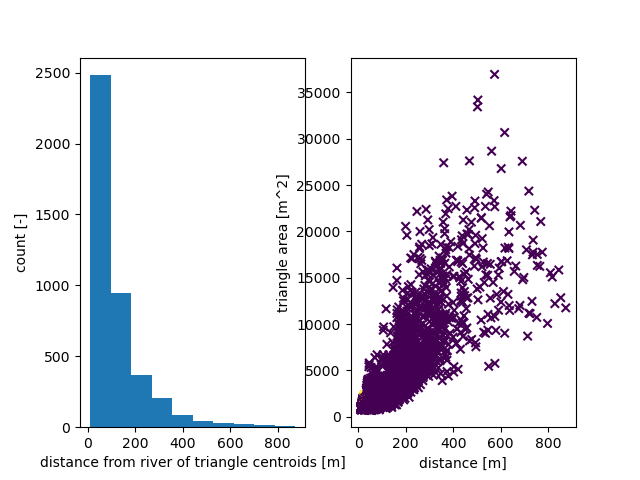

In [72]:
## Triangulation

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width)
widths = dict({1:8,2:12,3:16})

refine_d0 = 25
refine_d1 = 200
refine_A0 = 2000
refine_A1 = 40000

d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle, refine_distance=[d0,A0,d1,A1],
                                              diagnostics=True)

In [73]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), conn_list)

2024-11-10 15:49:54,865 - root - INFO: 
2024-11-10 15:49:54,866 - root - INFO: Loading Raster
2024-11-10 15:49:54,866 - root - INFO: ------------------------------
2024-11-10 15:49:54,866 - root - INFO: Loading file: '../../Coweeta_data/input_data/DEM/coweeta_dem.tif'
2024-11-10 15:49:54,866 - root - INFO: Collecting raster
2024-11-10 15:49:54,874 - root - INFO: bounds in my_crs: (-83.47845037186387, 35.02734099944037, -83.42165773504303, 35.07381933600275)
2024-11-10 15:49:54,875 - root - INFO: ... got raster of shape: (169, 206)
2024-11-10 15:49:54,876 - root - INFO: ... got raster bounds: (-83.47872814964133, 35.074097113780205, -83.4215059274172, 35.0271526693342)


kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x31f2bf760>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x31f2bfdc0>, 'edgecolor': 'k'}
setting face color =  [1366.86948746  902.41763407  942.50539221 ...  874.57965231  886.21624931
  896.01467586]


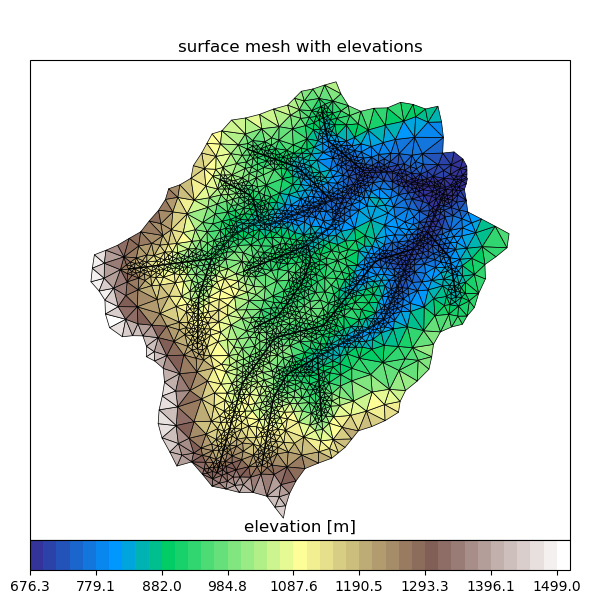

In [74]:
# plotting surface mesh with elevations
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='terrain')


fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.5 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

cbar.ax.set_title('elevation [m]')

plt.show()


### 3) Alternate river width options

We can also provide uniform widths for each reach. It could be from sites-specific surveys, remotely sensed data, engineering reports, etc.

In [79]:
# width function 
def widths_function(node):
    widths = dict({1:8,2:12,3:16})
    return widths.get(node.properties['StreamOrder'])

In [80]:
for river in rivers:
    for node in river.preOrder():
        node.properties['width'] = widths_function(node)

2024-11-10 16:01:59,054 - root - INFO: 
2024-11-10 16:01:59,055 - root - INFO: Stream-aligned Meshing
2024-11-10 16:01:59,055 - root - INFO: ------------------------------
2024-11-10 16:01:59,055 - root - INFO: treat stream triangles is set to None
2024-11-10 16:01:59,056 - root - INFO: Creating stream-aligned mesh...
2024-11-10 16:01:59,056 - root - INFO: River 0
2024-11-10 16:01:59,057 - root - INFO: ... generating initial polygon through dilation (4 m)
2024-11-10 16:01:59,059 - root - INFO:   -- treating collinearity
2024-11-10 16:01:59,064 - root - INFO:   -- river min seg length: 61.98201607276061
2024-11-10 16:01:59,064 - root - INFO:   -- merging points closer than 45.98201607276061 m along the river corridor
2024-11-10 16:01:59,143 - root - INFO: ... defining river-mesh topology (quad elements)
2024-11-10 16:01:59,159 - root - INFO: ... setting width of quad elements
2024-11-10 16:01:59,168 - root - INFO: ... enforcing convexity
2024-11-10 16:01:59,171 - root - INFO: Adjusting 

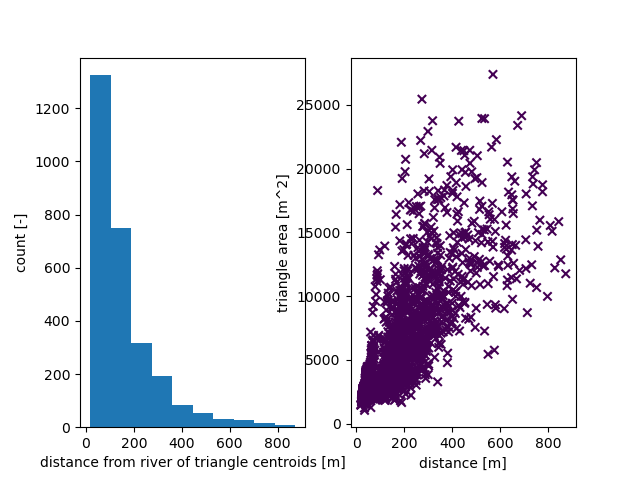

In [81]:
## Triangulation

# Refine triangles if they get too acute
min_angle = 32 # degrees

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=True,
                                              refine_min_angle=min_angle, refine_max_area=30000,
                                              diagnostics=True)


In [82]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), conn_list)

2024-11-10 16:02:03,536 - root - INFO: 
2024-11-10 16:02:03,537 - root - INFO: Loading Raster
2024-11-10 16:02:03,537 - root - INFO: ------------------------------
2024-11-10 16:02:03,538 - root - INFO: Loading file: '../../Coweeta_data/input_data/DEM/coweeta_dem.tif'
2024-11-10 16:02:03,538 - root - INFO: Collecting raster
2024-11-10 16:02:03,547 - root - INFO: bounds in my_crs: (-83.47845037186387, 35.02734099944037, -83.42165773504303, 35.07381933600275)
2024-11-10 16:02:03,549 - root - INFO: ... got raster of shape: (169, 206)
2024-11-10 16:02:03,550 - root - INFO: ... got raster bounds: (-83.47872814964133, 35.074097113780205, -83.4215059274172, 35.0271526693342)


/Users/7s2/opt/anaconda3/envs/watershed_workflow-pure/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x31fbfb550>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x31fbfb8e0>, 'edgecolor': 'k'}
setting face color =  [1341.90253697  692.39893454  777.7524677  ...  874.57965231  886.21624931
  896.01467586]


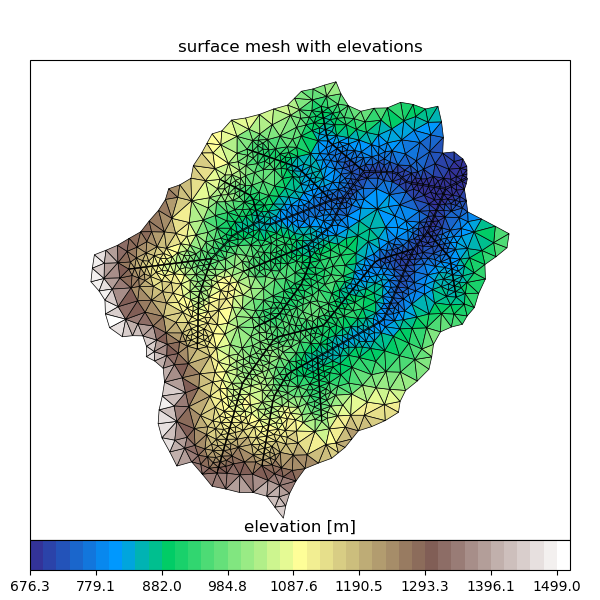

In [83]:
# plotting surface mesh with elevations
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='terrain')


fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.5 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

cbar.ax.set_title('elevation [m]')

plt.show()
